In [1]:
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.datasets
import sklearn.svm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

`SVM` is a very powerful and versatile Machine Learning model, capable of performing linear or nonlinear classification, regression, and even outlier detection. It is one of the most popular models in Machine Learning, and anyone interested in Machine Learning should have it in their toolbox. `SVM`s are particularly well suited for classification of complex but small- or medium-sized datasets.

## 5.1 Linear SVM Classification
The fundamental idea behind SVMs is best explained with some pictures. `Figure 5-1` shows part of the iris dataset. The two classes can clearly be separated easily with a straight line (they are linearly separable). The left plot shows the decision boundaries of three possible linear classifiers. The model whose decision boundary is represented by the dashed line is so bad that it does not even separate the classes properly. The other two models work perfectly on this training set, but their decision boundaries come so close to the instances that these models will probably not perform as well on new instances. In contrast, the solid line in the plot on the right represents the decision boundary of an SVM classifier; this line not only separates the two classes but also stays as far away from the closest training instances as possible. You can think of an SVM classifier as fitting the widest possible street (represented by the parallel dashed lines) between the classes. This is called `large margin classification`.
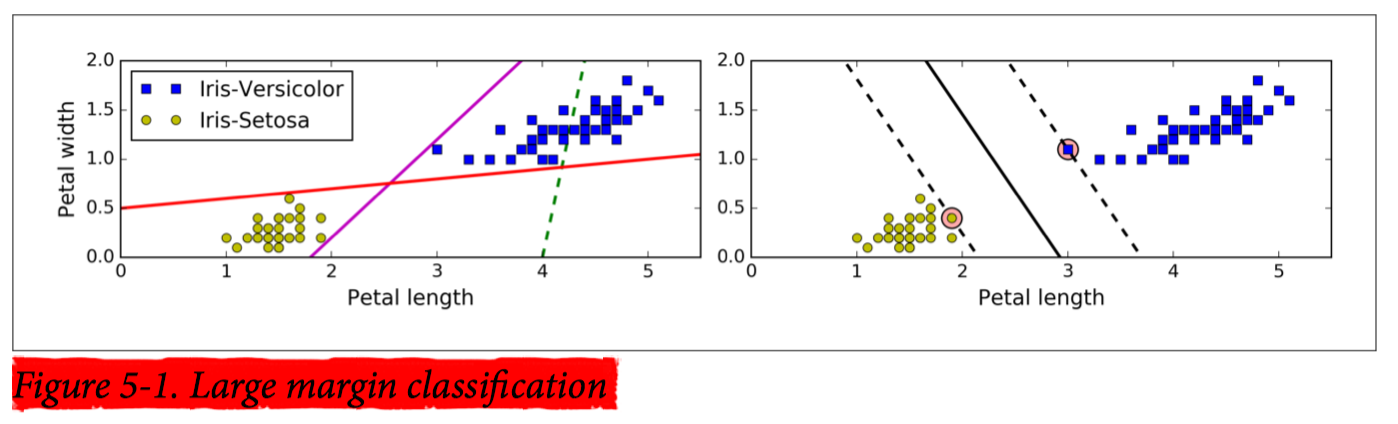

Notice that adding more training instances “off the street” will not affect the decision boundary at all: it is fully determined (or “supported”) by the instances located on the edge of the street. These instances are called the `support vectors` (they are circled in `Figure 5-1`).

SVMs are sensitive to the feature scales, as you can see in `Figure 5-2`: on the left plot, the vertical scale is much larger than the horizontal scale, so the widest possible street is close to horizontal. After feature scaling (using Scikit-Learn’s StandardScaler), the decision boundary looks much better (on the right plot):
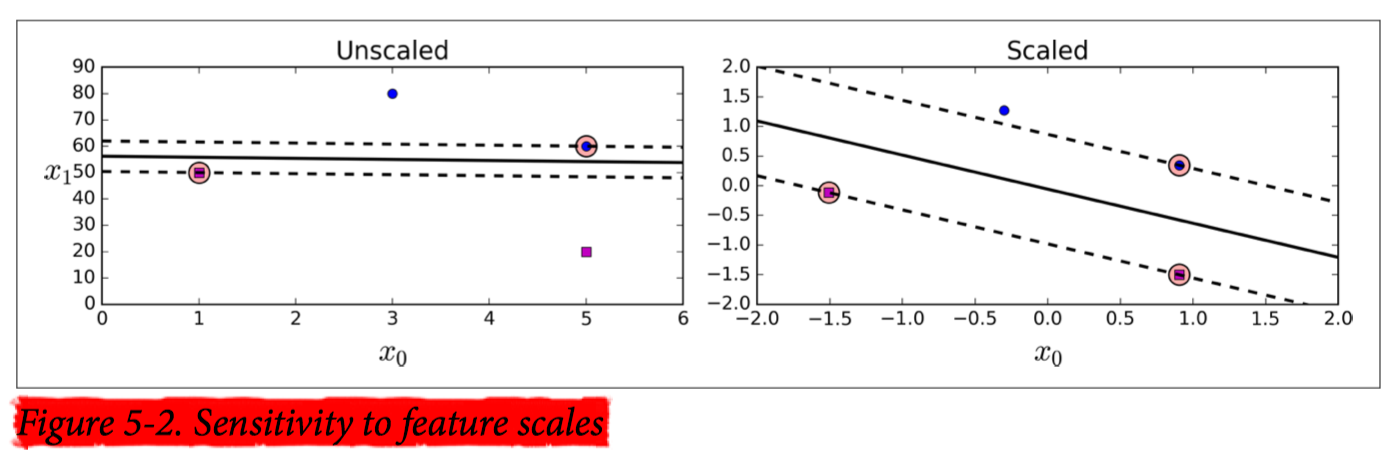

### 5.1.1 Soft Margin Classification
If we strictly impose that all instances be off the street and on the right side, this is called hard margin classification. There are two main issues with hard margin classification. First, it only works if the data is linearly separable, and second it is quite sensitive to outliers. `Figure 5-3` shows the iris dataset with just one additional outlier: on the left, it is impossible to find a hard margin, and on the right the decision boundary ends up very different from the one we saw in `Figure 5-1` without the outlier, and it will probably not generalize as well.
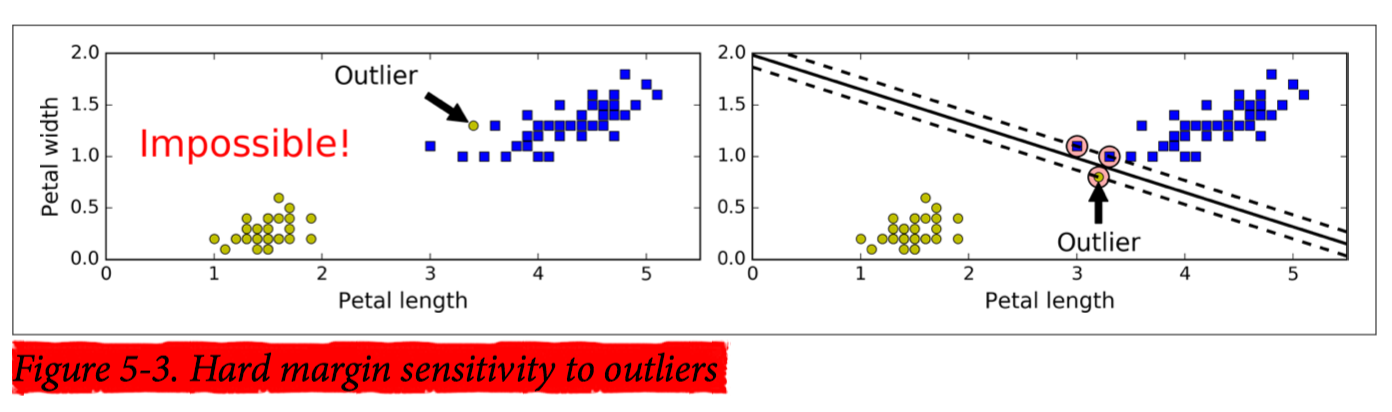

To avoid these issues it is preferable to use a more flexible model. The objective is to find a good balance between keeping the street as large as possible and limiting the margin violations (i.e., instances that end up in the middle of the street or even on the wrong side). This is called `soft margin classification`.

In Scikit-Learn’s SVM classes, you can control this balance using the `C` hyperparameter: a smaller `C` value leads to a wider street but more margin violations. 

`Figure 5-4` shows the decision boundaries and margins of two soft margin SVM classifiers on a nonlinearly separable dataset. On the left, using a high C value the classifier makes fewer margin violations but ends up with a smaller margin. On the right, using a low C value the margin is much larger, but many instances end up on the street. However, it seems likely that the second classifier will generalize better: in fact even on this training set it makes fewer prediction errors, since most of the margin violations are actually on the correct side of the decision boundary.
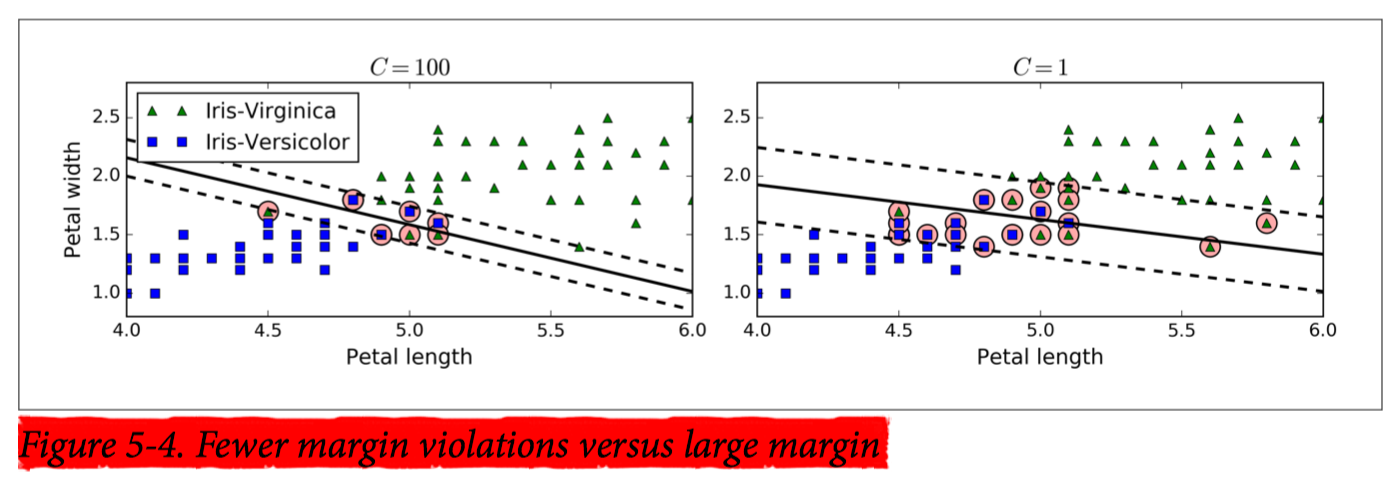

The following code trains a linear SVM model to detect Iris-Virginica flowers. The resulting model is represented on the right of` Figure 5-4`:

In [2]:
iris = sklearn.datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

svm_clf = sklearn.pipeline.Pipeline((
        ("scaler", sklearn.preprocessing.StandardScaler()),
        ("linear_svc", sklearn.svm.LinearSVC(C=1, loss="hinge", random_state=42)),
    ))

svm_clf.fit(X, y)
svm_clf.predict([[5.5, 1.7]])

array([ 1.])

Unlike Logistic Regression classifiers, SVM classifiers do not output probabilities for each class.

**Alternatively, you could use the SVC class, using SVC(kernel="linear", C=1), but it is much slower, especially with large training sets, so it is not recommended**. 

**Another option is to use the SGDClassifier class, with SGDClassifier(loss="hinge", alpha=1/(m*C)). This applies regular `Stochastic GD` to train a linear SVM classifier. It does not converge as fast as the LinearSVC class, but it can be useful to handle huge datasets that do not fit in memory (out-of-core training), or to handle online classification tasks**.

> The LinearSVC class regularizes the bias term, so you should center the training set first by subtracting its mean. This is automatic if you scale the data using the StandardScaler. Moreover, make sure you set the `loss` hyperparameter to "hinge", as it is not the default value. Finally, for better performance you should set the `dual` hyperparameter to False, unless there are more features than training instances (we will discuss duality later in the chapter).

## 5.2 Nonlinear SVM Classification
Although linear SVM classifiers are efficient and work surprisingly well in many cases, many datasets are not even close to being linearly separable. One approach to handling nonlinear datasets is to add more features, such as polynomial features; in some cases this can result in a linearly separable dataset. Consider the left plot in `Figure 5-5`: it represents a simple dataset with just one feature x 1 . This dataset is not linearly separable, as you can see. But if you add a second feature $x_2 = (x_1)^2$, the resulting 2D dataset is perfectly linearly separable:
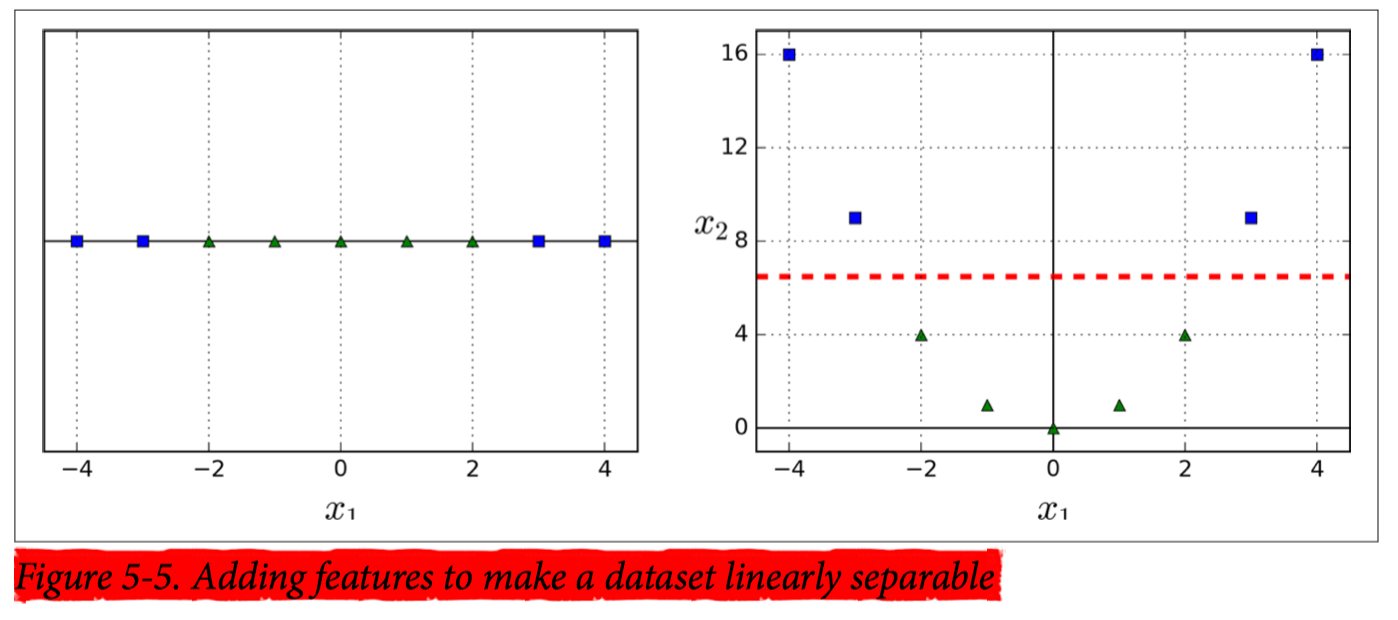

Let's test this idea on the moons dataset:

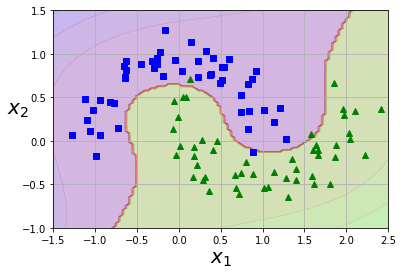

In [3]:
X, y = sklearn.datasets.make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

polynomial_svm_clf = sklearn.pipeline.Pipeline((
        ("poly_features", sklearn.preprocessing.PolynomialFeatures(degree=3)),
        ("scaler", sklearn.preprocessing.StandardScaler()),
        ("svm_clf", sklearn.svm.LinearSVC(C=10, loss="hinge", random_state=42))
    ))

polynomial_svm_clf.fit(X, y)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

### 5.2.1 Polynomial Kernel
Adding polynomial features is simple to implement and can work great with all sorts of Machine Learning algorithms (not just SVMs), but at a low polynomial degree it cannot deal with very complex datasets, and with a high polynomial degree it creates a huge number of features, making the model too slow.

Fortunately, when using SVMs you can apply an almost miraculous mathematical technique called the `kernel trick`. It makes it possible to get the same result as if you added many polynomial features, even with very highdegree polynomials, without actually having to add them, so there is no combinatorial explosion of the number of features. 

This trick is implemented by the SVC class. Let’s test it on the moons dataset:

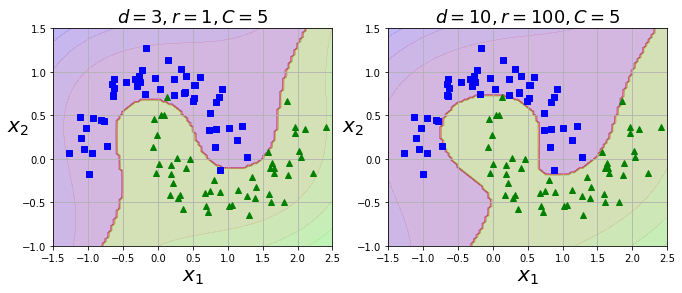

In [4]:
poly_kernel_svm_clf = sklearn.pipeline.Pipeline((
        ("scaler", sklearn.preprocessing.StandardScaler()),
        ("svm_clf", sklearn.svm.SVC(kernel="poly", degree=3, coef0=1, C=5))
    ))
poly_kernel_svm_clf.fit(X, y)

poly100_kernel_svm_clf = sklearn.pipeline.Pipeline((
        ("scaler", sklearn.preprocessing.StandardScaler()),
        ("svm_clf", sklearn.svm.SVC(kernel="poly", degree=10, coef0=100, C=5))
    ))
poly100_kernel_svm_clf.fit(X, y)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.subplot(122)
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)

plt.show()

On the left is a SVM classifier using a $3^{rd}$-degree polynomial kernel. On the right is another SVM classifier using a $10^{th}$-degree polynomial kernel. Obviously, if your model is overfitting, you might want to reduce the polynomial degree. Conversely, if it is underfitting, you can try increasing it. The hyperparameter `coef0` controls how much the model is influenced by highdegree polynomials versus low-degree polynomials.

### 5.2.2 Adding Similarity Features
Another technique to tackle nonlinear problems is to add features computed using a `similarity function` that measures how much each instance resembles a particular landmark. 

For example, let’s take the one-dimensional dataset discussed earlier and add two landmarks to it at $x_1 = -2$ and $x_1 = 1$ (see the left plot in `Figure 5-8`). 
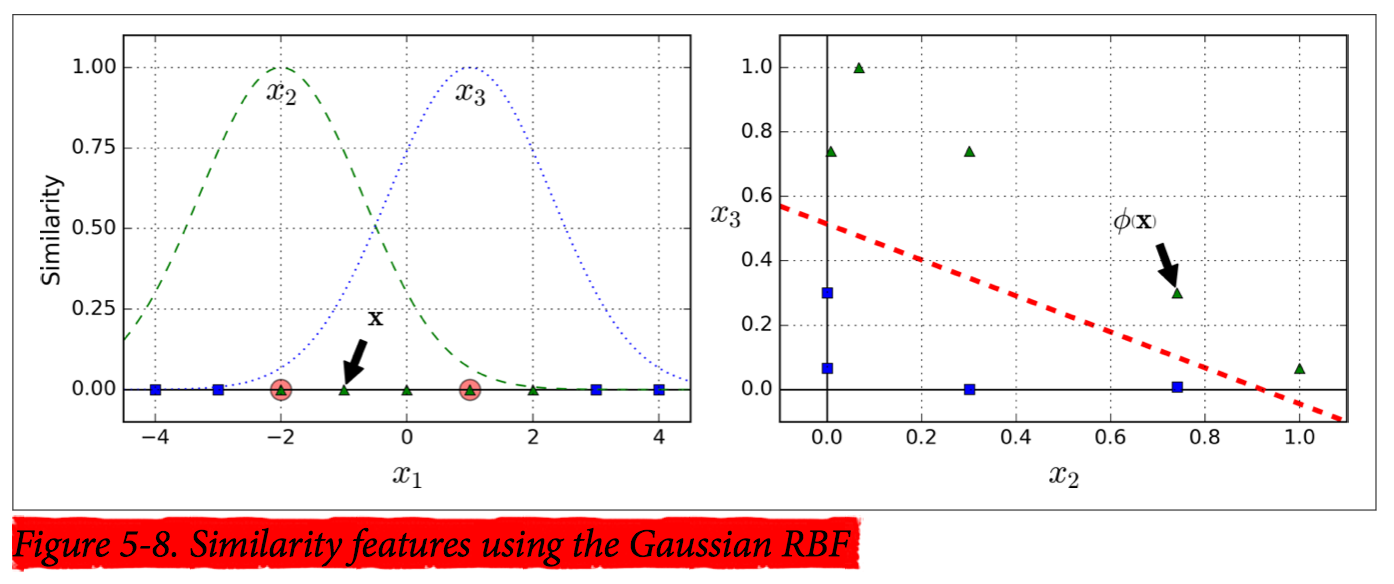

Next, let’s define the `similarity function` to be the `Gaussian Radial Basis Function` (RBF) with $\gamma = 0.3$ (see `Equation 5-1`):
- $\phi\gamma(\mathrm{x},\ell) = exp(-\gamma \Vert \mathrm{x}-\ell \Vert^2)$

It is a bell-shaped function varying from 0 (very far away from the landmark) to 1 (at the landmark). Now we are ready to compute the new features. For example, let’s look at the instance $x_1 = -1$: it is located at a distance of 1 from the first landmark, and 2 from the second landmark. Therefore its new features are $x_2 = e^{(-0.3*1^2)} ≈ 0.74$ and $x_3 = e^{(-0.3*2^2)} ≈ 0.30$. The plot on the right of `Figure 5-8` shows the transformed dataset (dropping the original features). As you can see, it is now linearly separable.

You may wonder how to select the landmarks. The simplest approach is to create a landmark at the location of each and every instance in the dataset. This creates many dimensions and thus increases the chances that the transformed training set will be linearly separable. The downside is that a training set with `m` instances and `n` features gets transformed into a training set with `m` instances and `m` features (assuming you drop the original features). If your training set is very large, you end up with an equally large number of features.

### 5.2.3 Gaussian RBF Kernel
Just like the polynomial features method, the similarity features method can be useful with any Machine Learning algorithm, but it may be computationally expensive to compute all the additional features, especially on large training sets. However, once again the kernel trick does its SVM magic: it makes it possible to obtain a similar result as if you had added many similarity features, without actually having to add them. 

Let’s try the Gaussian RBF kernel using the SVC class:

In [5]:
rbf_kernel_svm_clf = sklearn.pipeline.Pipeline((
        ("scaler", sklearn.preprocessing.StandardScaler()),
        ("svm_clf", sklearn.svm.SVC(kernel="rbf", gamma=5, C=0.001))
    ))
rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

This model is represented on the bottom left of `Figure 5-9`. The other plots show models trained with different values of hyperparameters $\gamma$ and `C`. Increasing $\gamma$ makes the bell-shape curve narrower, and as a result each instance’s range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual instances. Conversely, a small gamma value makes the bell-shaped curve wider, so instances have a larger range of influence, and the decision boundary ends up smoother. So $\gamma$ acts like a regularization hyperparameter: if your model is overfitting, you should reduce it, and if it is underfitting, you should increase it.

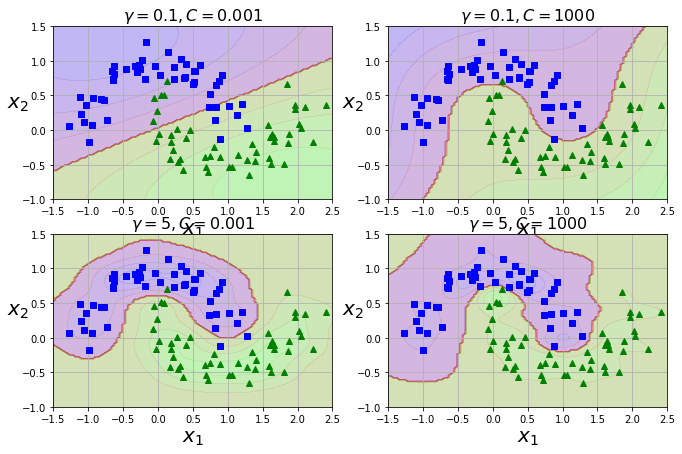

In [6]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = sklearn.pipeline.Pipeline((
            ("scaler", sklearn.preprocessing.StandardScaler()),
            ("svm_clf", sklearn.svm.SVC(kernel="rbf", gamma=gamma, C=C))
        ))
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(11, 7))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)

plt.show()

Other kernels exist but are used much more rarely. For example, some kernels are specialized for specific data structures. String kernels are sometimes used when classifying text documents or DNA sequences (e.g., using the string subsequence kernel or kernels based on the Levenshtein distance).

> With so many kernels to choose from, how can you decide which one to use? As a rule of thumb, you should always try the `linear kernel` first (remember that LinearSVC is much faster than SVC(ker nel="linear")), especially if the training set is very large or if it has plenty of features. If the training set is not too large, you should try the `Gaussian RBF kernel` as well; it works well in most cases. Then if you have spare time and computing power, you can also experiment with a few other kernels using cross-validation and grid search, especially if there are kernels specialized for your training set’s data structure.

### 5.2.4 Computational Complexity
The LinearSVC class is based on the liblinear library, which implements an optimized algorithm for linear SVMs. It does not support the kernel trick, but it scales almost linearly with the number of training instances and the number of features: its training time complexity is roughly $O(m*n)$.

The algorithm takes longer if you require a very high precision. This is controlled by the tolerance hyperparameter $\epsilon$. In most classification tasks, the default tolerance is fine.

The SVC class is based on the libsvm library, which implements an algorithm that supports the kernel trick. The training time complexity is usually between $O(m^2*n)$ and $O(m^3*n)$. Unfortunately, this means that it gets dreadfully slow when the number of training instances gets large. This algorithm is perfect for complex but small or medium training sets. However, it scales well with the number of features, especially with sparse features (i.e., when each instance has few nonzero features). In this case, the algorithm scales roughly with the average number of nonzero features per instance. 

`Table 5-1` compares Scikit-Learn’s SVM classification classes:
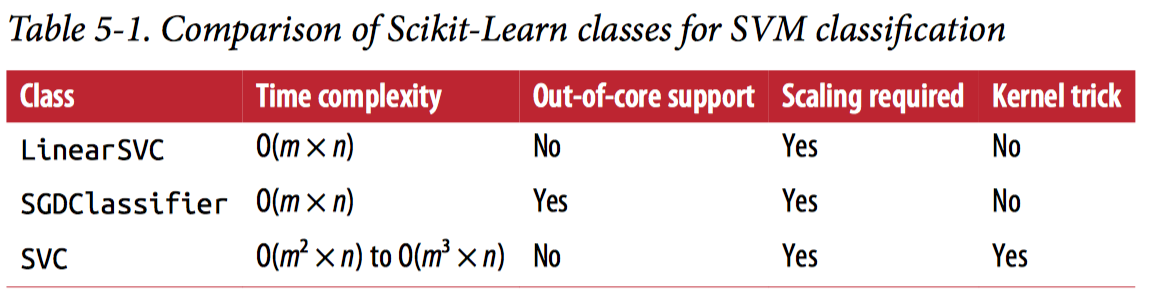

## 5.3 SVM Regression
SVM algorithm is quite versatile: it supports linear and nonlinear classification, it also supports linear and nonlinear regression. The trick is to reverse the objective: instead of trying to fit the largest possible street between two classes while limiting margin violations, SVM Regression tries to fit as many instances as possible on the street while limiting margin violations (i.e., instances off the street). The width of the street is controlled by a hyperparameter $\epsilon$. `Figure 5-10` shows two linear SVM Regression models trained on some random linear data, one with a large margin ($\epsilon = 1.5$) and the other with a small margin ($\epsilon = 0.5$):
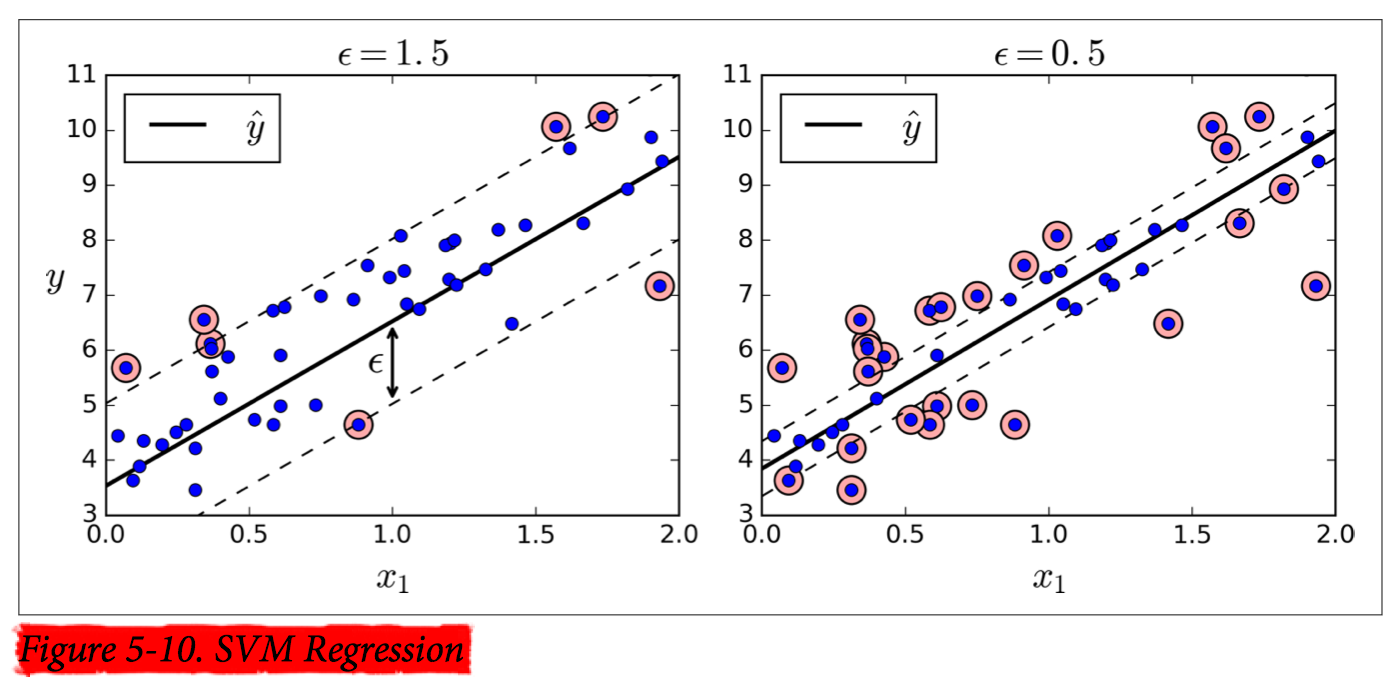

Adding more training instances within the margin does not affect the model’s predictions; thus, the model is said to be $\epsilon$-insensitive.

You can use Scikit-Learn’s LinearSVR class to perform linear SVM Regression. The following code produces the model represented on the left of Figure `5-10` (the training data should be scaled and centered first):
```python
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5) 
svm_reg.fit(X, y)
```

To tackle nonlinear regression tasks, you can use a kernelized SVM model. For example, `Figure 5-11` shows SVM Regression on a random quadratic training set, using a $2^{nd}$-degree polynomial kernel. There is little regularization on the left plot (i.e., a large `C` value), and much more regularization on the right plot (i.e., a small `C` value):

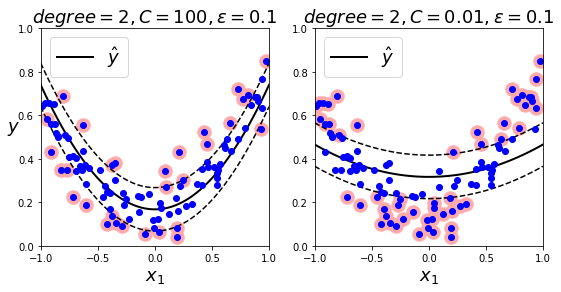

In [9]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

svm_poly_reg1 = sklearn.svm.SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg2 = sklearn.svm.SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1)
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(
    svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.subplot(122)
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(
    svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
plt.show()

The following code produces the model represented on the left of `Figure 5-11` using Scikit-Learn’s SVR class. The SVR class is the regression equivalent of the SVC class, and the LinearSVR class is the regression equivalent of the LinearSVC class. The LinearSVR class scales linearly with the size of the training set, while the SVR class gets much too slow when the training set grows large:
```python
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1) 
svm_poly_reg.fit(X, y)
```



## 5.4 Under the Hood
This section explains how SVMs make predictions and how their training algorithms work, starting with linear SVM classifiers.

First, a word about notations: in `Chapter 4` we used the convention of putting all the model parameters in one vector $\theta$, including the bias term $\theta_0$ and the input feature weights $\theta_1$ to $\theta_n$, and adding a bias input $x_0 = 1$ to all instances. In this chapter, we will use a different convention, which is more convenient when you are dealing with SVMs: the bias term will be called $b$ and the feature weights vector will be called $w$. No bias feature will be added to the input feature vectors.

### 5.4.1 Decision Function and Predictions
The linear SVM classifier model predicts the class of a new instance $x$ by simply computing the decision function $w^T\cdot x+b = w_1x_1+ ⋯ +w_nx_n + b$: if the result is positive, the predicted class $\hat{y}$ is the positive class, or else it is the negative class; see `Equation 5-2`:
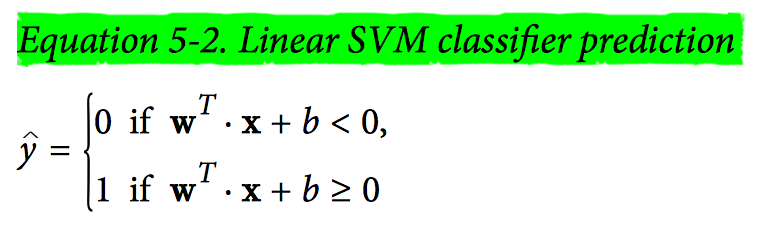

`Figure 5-12` shows the decision function that corresponds to the model on the right of `Figure 5-4`: it is a two-dimensional plane since this dataset has two features (petal width and petal length). The decision boundary is the set of points where the decision function is equal to 0: it is the intersection of two planes, which is a straight line (represented by the thick solid line):
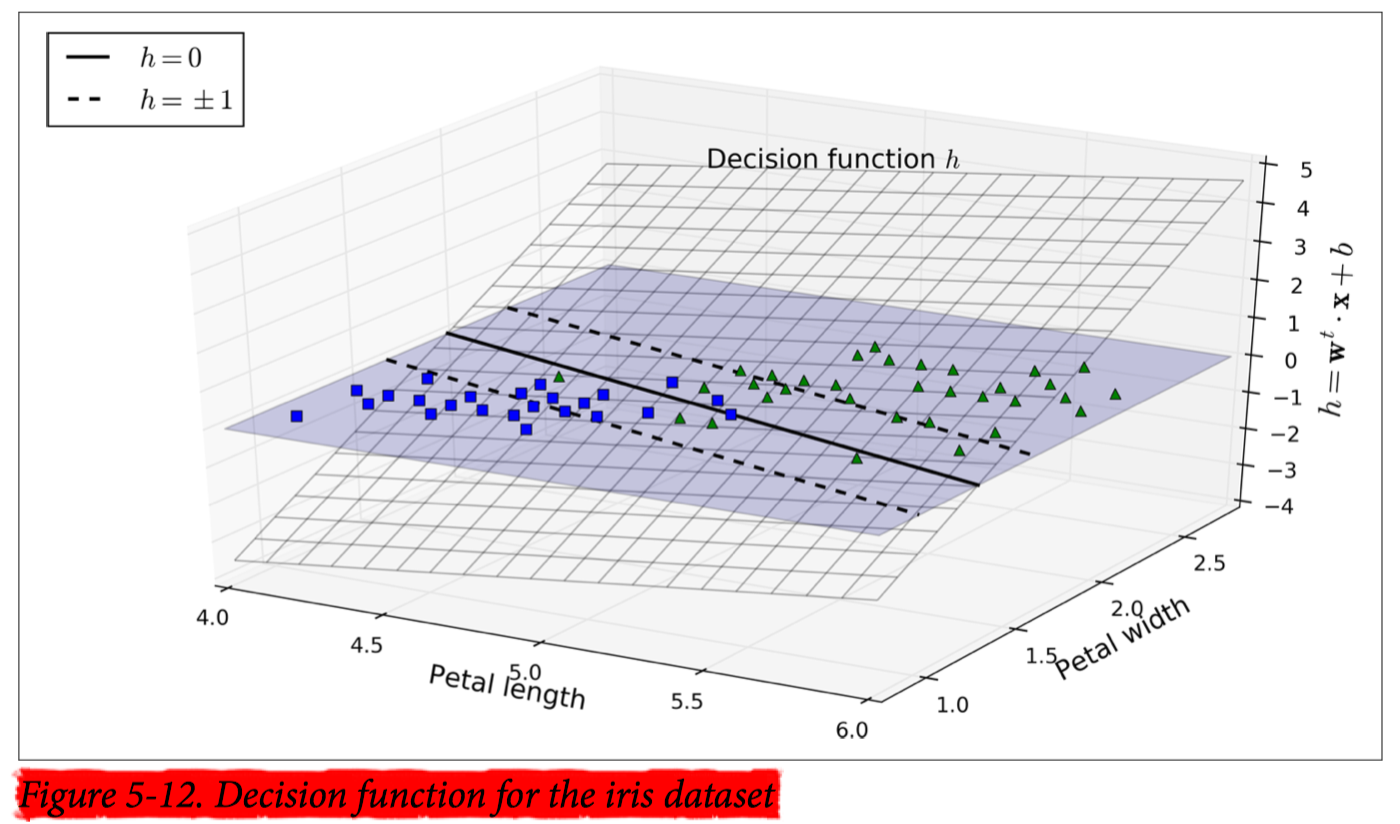

The dashed lines represent the points where the decision function is equal to 1 or –1: they are parallel and at equal distance to the decision boundary, forming a margin around it. Training a linear SVM classifier means finding the value of w and b that make this margin as wide as possible while avoiding margin violations (hard margin) or limiting them (soft margin).

### 5.4.2 Training Objective
Consider the slope of the decision function: it is equal to the norm of the weight vector, $\Vert w\Vert$. If we divide this slope by 2, the points where the decision function is equal to $\pm 1$ are going to be twice as far away from the decision boundary. In other words, dividing the slope by 2 will multiply the margin by 2. 

Perhaps this is easier to visualize in 2D in `Figure 5-13`. The smaller the weight vector $\mathrm{w}$, the larger the margin:
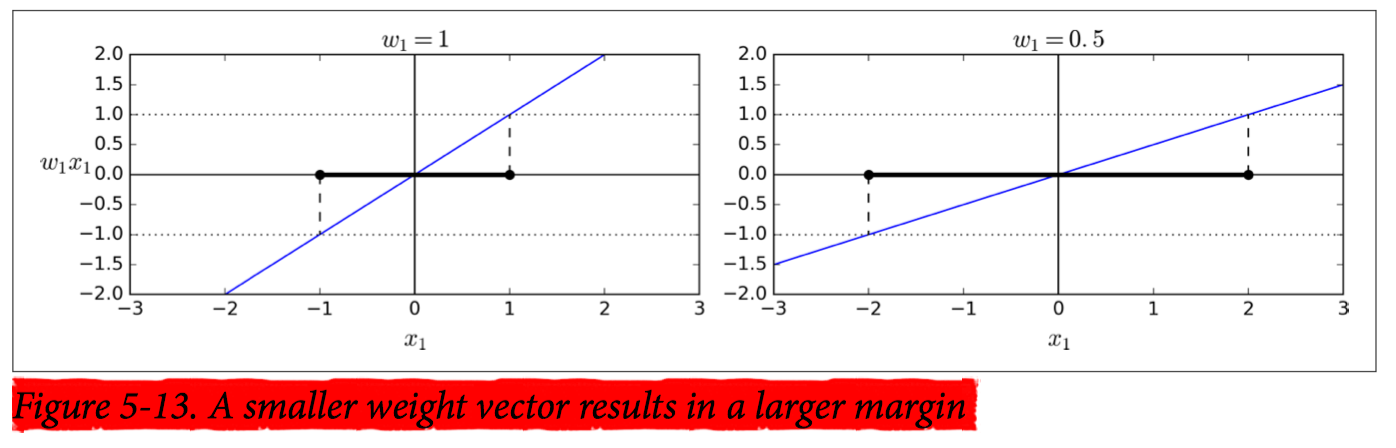

So we want to minimize $\Vert w\Vert$ to get a large margin. However, if we also want to avoid any margin violation (hard margin), then we need the decision function to be greater than 1 for all positive training instances, and lower than –1 for negative training instances. If we define $t^{(i)} = -1$ for negative instances (if $y^{(i)} = 0$) and $t^{(i)} = 1$ for positive instances (if $y^{(i)} = 1$), then we can express this constraint as $t^{(i)}(w^T \cdot x^{(i)} + b) \ge 1$ for all instances.

We can therefore express the hard margin linear SVM classifier objective as the constrained optimization problem in `Equation 5-3`:
- $\underset{\mathrm{w},b}{\mathrm{minimize}}\quad \frac{1}{2}\mathrm{w}^T\cdot \mathrm{w}$
- $subject\ to\quad t^{(i)}(w^T \cdot x^{(i)} + b) \ge 1\ for\ i=1,2,3...,m$

> We are minimizing $\frac{1}{2}\mathrm{w}^T\cdot \mathrm{w}$, which is equal to $2\Vert \mathrm{w}\Vert^2$, rather than minimizing $\Vert \mathrm{w}\Vert$. This is because it will give the same result (since the values of $\mathrm{w}$ and $b$ that minimize a value also minimize half of its square), but $\frac{1}{2}\Vert \mathrm{w}\Vert^2$ has a nice and simple derivative (it is just $\mathrm{w}$) while $\mathrm{w}$ is not differentiable at $\mathrm{w} = 0$. Optimization algorithms work much better on differentiable functions.

To get the soft margin objective, we need to introduce a `slack variable` $\zeta^{(i)} \ge 0$ for each instance: $\zeta^{(i)}$ measures how much the $i^{th}$ instance is allowed to violate the margin. We now have two conflicting objectives: making the slack variables as small as possible to 1 reduce the margin violations, and making $\frac{1}{2}\Vert \mathrm{w}\Vert^2$ as small as possible to increase the margin. This is where the `C` hyperparameter comes in: it allows us to define the trade‐off between these two objectives. This gives us the constrained optimization problem in `Equation 5-4`:
- $\underset{\mathrm{w},b,\zeta}{\mathrm{minimize}}\quad \frac{1}{2}\mathrm{w}^T\cdot \mathrm{w}+C\sum_{i=1}^{m}\zeta^{(i)}$
- $subject\ to\quad t^{(i)}(w^T \cdot x^{(i)} + b) \ge 1-\zeta^{(i)}\quad and \quad \zeta^{(i)} \ge 0,\quad for\ i=1,2,3...,m$

**剩余的内容过于深奥，回头研究SVM原理时再看。**